## This is the third introductory example for the pyioflash library

First we need to import the necessary python modules for this example and set matplotlib to inline for the notebook

In [1]:
from sys import stdout
import numpy
from matplotlib import pyplot, colorbar, cm, colors, animation
from IPython.display import HTML

We need to import the necessary packages from the pyioflash library.

In this case we will need the same packages as the last notebook.

In [2]:
from pyioflash import SimulationData, sources, elements, analyses

Again we are going to read in the simulation data into a management object

In [3]:
data = SimulationData.from_list(range(61), path='data/', basename='INS_Rayleigh_', header='hdf5_plt_cnt_')


############    Building SImulationData Object   ############

Processing metadata from: data/INS_Rayleigh_hdf5_plt_cnt_0000
Reading Grid from File
Processing file: data/INS_Rayleigh_hdf5_plt_cnt_0060

#############################################################




For this example let's try to plot the integral energies within the Rayleigh cell as a function of time.

Again, the series module in the analyses package provides a time-series analysis method that will serve our purpose, simple. Let's see how to use it with a stack this time.

    result = series.simple(source, sourceby, stack)
    
There are a number of ways to operate on the results returned by the source using a 'stack of elements'. We are going to use a helper method provided in the analyses package, make_stackable, to turn one of the methods provided in the elements package, integral.space_full, into a usable stack function for the simple method.

    make_stackable(element, args=..., method='{Stack Method}', options={'option': value, ...})
    
Now there is a lot of elements here ... that was a joke ... again ... ok, a bad one but can you keep blaming me.

We are going to use this as follows:

    space = analyses.make_stackeable(elements.integral.space_full, data, method='part')
                                       
Let's breakdown the arguments one at a time:

    1) elements.integral.space_full -- the intended method for computing a spatial integral
    
    2) data -- the only args we need to provide is data as when the simple method is called with
               this element in the stack it will perform the operation on each of the items in 
               the time-series returned by the source
               
    3) method='part' -- this argument is not important now, it just tells the helper method that we are going to be acting
                        on each item in the series in isolation vice some more ellaborate method
                        
    4) options={...} -- not used, but here we are providing the keyword arguments as necessary
    
    
Now let's try this out

In [4]:
# Let's get the simulation times
times = data.utility.times()

# We are going to need to define a spatial integration operator
space = analyses.make_stackable(elements.integral.space_full, data, method='part')

# Let's get the thermal energy
source = analyses.make_sourceable(sources.energy.thermal, data, method='step')
thermal_energy = analyses.series.simple(source=source, sourceby=range(61), stack=space)

# Let's get the instantanious kinetic energy
source = analyses.make_sourceable(sources.energy.kinetic, data, method='step')
kinetic_energy = analyses.series.simple(source=source, sourceby=range(61), stack=space)

# Let's get the turbulant kinetic energy, using t=50-60 seconds for the mean kinetic energy
mean = sources.fields.velocity_mean(data, start=50.0, stop=60.0)
source = analyses.make_sourceable(sources.energy.kinetic_turbulant, data, method='step', options={'mean': mean})
turbulant_energy = analyses.series.simple(source=source, sourceby=range(61), stack=space)

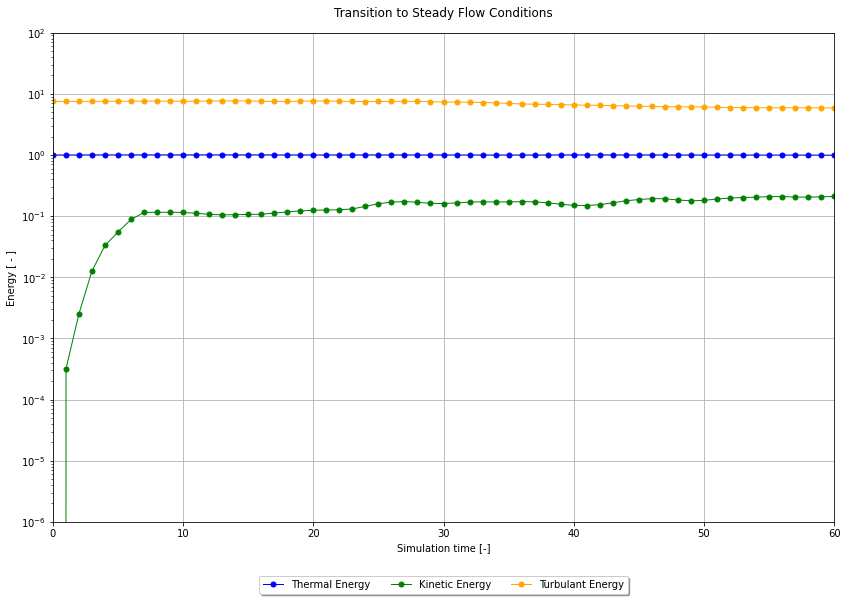

In [5]:
# create figure or sub figures
fig, ax = pyplot.subplots(figsize=(14, 9))

ax.semilogy(times, thermal_energy,
                label="Thermal Energy", color="blue",  linestyle="-", linewidth=1.0, marker='o', markersize=5.0)

ax.semilogy(times, kinetic_energy,
                label="Kinetic Energy", color="green", linestyle="-", linewidth=1.0, marker='o', markersize=5.0)

ax.semilogy(times, turbulant_energy,
                label="Turbulant Energy", color="orange", linestyle="-", linewidth=1.0, marker='o', markersize=5.0)

ax.set_xlim(times[0], times[-1])
ax.set_ylim(10**-6, 10**2)
ax.grid(which='major', linestyle='-')

ax.set_title("Transition to Steady Flow Conditions", y=1.02)
ax.set_xlabel("Simulation time [-]", y=-0.10)
ax.set_ylabel("Energy [ - ]", x=-0.10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=3, fancybox=True, shadow=True);

For this next example let's try to determine the time averaged integral turbulant kinetic energy within the Rayleigh cell.

We are again going to use the series.simple method with the addition of a time integral on the stack, as follows:

    time = analyses.make_stackeable(elements.integral.time, data, method='whole', options={'times': times})
                                       
Let's breakdown the arguments one at a time:

    1) elements.integral.time -- the intended method for computing a temporal integral
    
    2) data -- the only args we need to provide is data as when the simple method is called with
               this element in the stack it will perform the operation on the time-series returned
               by the previous stack operation
               
    3) method='whole' -- this argument is not important now, it just tells the helper method that we are going to be acting
                         on all the item in the series as a collection
                        
    4) options={'times': times} -- here we are providing the times so that the integral method can lookup the correct 
                                   differential time elements (e.g., delta_t)
    
    
Now let's try this out

In [6]:
times = data.utility.times(slice(50.0, 60.0))

space = analyses.make_stackable(elements.integral.space_full, data, method='part')
time = analyses.make_stackable(elements.integral.time, data, method='whole', options={'times': times}) 

mean = sources.fields.velocity_mean(data, start=50.0, stop=60.0)
source = analyses.make_sourceable(sources.energy.kinetic_turbulant, data, method='step', 
                                  options={'mean': mean})
analyses.series.simple(source=source, sourceby=times, stack=(space, time)) / (times[-1] - times[0])

5.936843000533595